# Flower Recognition using Pre-trained model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pathlib
import os

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import Sequential, layers
from tensorflow.keras.preprocessing.image import load_img

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Sample images

In [2]:
flowers_dir = './flowers_1'
flower_labels = sorted(os.listdir(flowers_dir))
flower_labels

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

## Data Preprocessing

* Iterate through all images
* Resize image into (299,299,3) since the model expects this input shape
* Convert image into numpy array
* Append features in X and labels in y

In [3]:
img_height = 299
img_width = 299

X = []
y = []
flowers_dir_path_object = pathlib.Path(flowers_dir)
for label_number,flower in enumerate(flower_labels):
    # get all paths of images inside flower subdirectory
    flower_images_paths = list(flowers_dir_path_object.glob(f'{flower}/*.jpg'))
    for image in flower_images_paths:
        # load and resize image
        resized_image = load_img(str(image),target_size=(img_height,img_width))
        # append features in X and labels in y
        X.append(np.array(resized_image))
        y.append(label_number)

In [4]:
X = np.array(X)
y = np.array(y)

print('X shape: {}'.format(X.shape))
print('y shape: {}'.format(y.shape))

X shape: (4317, 299, 299, 3)
y shape: (4317,)


## Model Building

* Train test split
* Fine-tuning pre-trained model
* Model evaluation

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

print('X train shape: {}'.format(X_train.shape))
print('X test shape: {}'.format(X_test.shape))

X train shape: (3237, 299, 299, 3)
X test shape: (1080, 299, 299, 3)


In [7]:
# https://tfhub.dev/google/cropnet/feature_vector/concat/1
# https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4
model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4",trainable=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(100, activation='softmax')
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_2 (Dense)             (None, 64)                131136    
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 21,934,245
Trainable params: 131,461
Non-trainable params: 21,802,784
_________________________________________________________________


In [9]:
history = model.fit(X_train,y_train,batch_size=64,validation_split=0.2,epochs=10)

Epoch 1/10


41/41 [==============================] - 3s 69ms/step - loss: 0.1478 - accuracy: 0.9602 - val_loss: 0.3073 - val_accuracy: 0.8951
Epoch 2/10
41/41 [==============================] - 3s 67ms/step - loss: 0.1391 - accuracy: 0.9598 - val_loss: 0.3149 - val_accuracy: 0.8935
Epoch 3/10
41/41 [==============================] - 3s 67ms/step - loss: 0.1167 - accuracy: 0.9718 - val_loss: 0.3950 - val_accuracy: 0.8812
Epoch 4/10
41/41 [==============================] - 3s 67ms/step - loss: 0.1048 - accuracy: 0.9733 - val_loss: 0.3288 - val_accuracy: 0.9012
Epoch 5/10
41/41 [==============================] - 3s 67ms/step - loss: 0.0819 - accuracy: 0.9822 - val_loss: 0.3193 - val_accuracy: 0.9012
Epoch 6/10
41/41 [==============================] - 3s 67ms/step - loss: 0.0703 - accuracy: 0.9876 - val_loss: 0.3305 - val_accuracy: 0.8935
Epoch 7/10
41/41 [==============================] - 3s 67ms/step - loss: 0.0734 - accuracy: 0.9822 - val_loss: 0.3317 - val_accuracy: 0.9028
Epoch 8/10
41/41 [======

In [10]:
model.evaluate(X_test,y_test)

 5/34 [===>..........................] - ETA: 0s - loss: 0.2968 - accuracy: 0.9062

34/34 [==============================] - 1s 29ms/step - loss: 0.3409 - accuracy: 0.8926


[0.3409472405910492, 0.8925925493240356]

In [11]:
predictions = model.predict(X_test)
max_predictions = [np.argmax(value) for value in predictions]
max_predictions[:5]

34/34 [==============================] - 1s 29ms/step


[3, 1, 1, 0, 4]

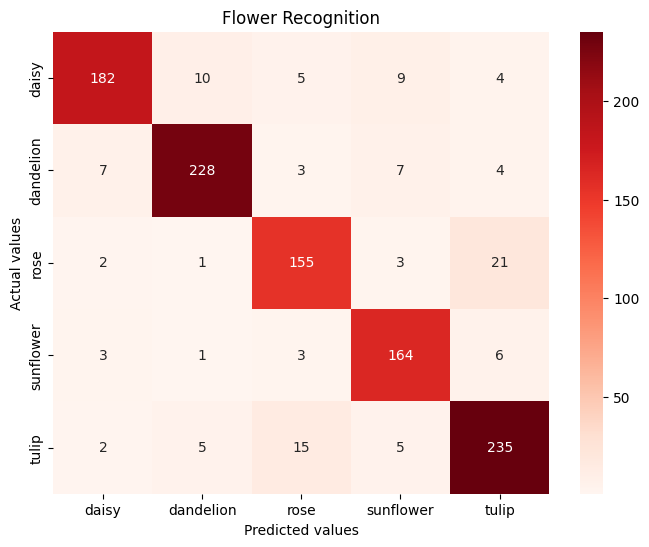

In [12]:
confusion_matrix_result = confusion_matrix(y_test,max_predictions)
 
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix_result,annot=True,cmap='Reds',fmt='.0f',xticklabels=flower_labels,yticklabels=flower_labels)
plt.title('Flower Recognition')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()

In [13]:
classification_report_result = classification_report(y_test,max_predictions)
print(classification_report_result)

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       210
           1       0.93      0.92      0.92       249
           2       0.86      0.85      0.85       182
           3       0.87      0.93      0.90       177
           4       0.87      0.90      0.88       262

    accuracy                           0.89      1080
   macro avg       0.89      0.89      0.89      1080
weighted avg       0.89      0.89      0.89      1080



## Saving the model

In [14]:
model.save('./flowers_test.h5')